## Operationalizing the Machine Learning Development Life Cycle

### Introduction: Home Loan Approval Prediction Model
### Story Board
### Banks are getting thousand of home loan applications every day. Manually evaluating each of application through bank employees is time consuming and involve human bias
### CustomerA of ACME Financials connects to their web site to request a new home loan. He/she inputs the required information and apply for the loan. The system returns the approval status within seconds
### Data Scientists at ACME Financials are monitoring the effectiveness of the home loan prediction model and detect some data drift.
### Data Scientists retrain and update the model to provide better prediction
### The new model is released and deployed to production
### Another Customer B (with similar profile as Customer A) apply for a home loan and the approval status is returned within seconds using the new model


#### Conda Env : General Machine Learning p37 gpu V1

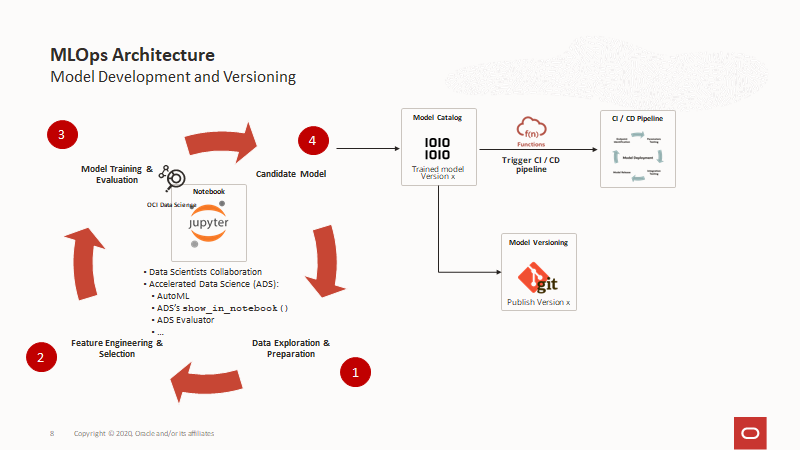

In [1]:
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])

import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"

ocid1.compartment.oc1..aaaaaaaalho3nlj4ewtx3ydrh5x4qq4yobppbdaqki2f2xedlja7iaqjuxvq
ocid1.datascienceproject.oc1.iad.amaaaaaap77apcqalweo3z7tugc7kj7awukfjdhawrezi6h6reimzli4hofa
ocid1.saml2idp.oc1..aaaaaaaalspuf6veu3mi3hlorcohfxog3qdsz3dhvvtxg3sjjpakvyb2oeya/rishi.r.yadav@oracle.com
ocid1.tenancy.oc1..aaaaaaaa5nras26nkpnlcd4g3ox6gfmzjaahxwb245stlrh7krkfrpu2nu5q
us-ashburn-1


In [2]:
#I have already create a project inside a data science project and already opened up a Notebook 
#I have all of these commands to bring the libraries in.
import io
import os
from os import path 
from os.path import expanduser
from os.path import join
import logging
import warnings
import pandas as pd
import numpy as np
import tempfile
from category_encoders.ordinal import OrdinalEncoder
from collections import defaultdict

import oci
#import ads
import matplotlib.pyplot as plt
import seaborn as sns
import ocifs
from ads.dataset.factory import DatasetFactory
from ads.dataset.dataset_browser import DatasetBrowser
from ads.common.model import ADSModel
from ads.dataset.factory import DatasetFactory
from ads.evaluations.evaluator import ADSEvaluator
from ads import set_auth


#from ads import set_documentation_mode
from oci.auth.signers import get_resource_principals_signer
from oci.data_science import DataScienceClient
from os import popen
from sklearn.base import TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import get_scorer
#### Resource Principals Authentication using the ADS SDK
import ads 
ads.set_auth(auth='resource_principal')

#set_documentation_mode(False)
warnings.filterwarnings('ignore')
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)


In [3]:
#### Resource Principals Authentication using the ADS SDK
#set_auth(auth='resource_principal') 
resource_principal = get_resource_principals_signer() 
dsc = DataScienceClient(config={}, signer=resource_principal)
#### Resource Principals Authentication using the OCI CLI
#cmd = "oci data-science project get --project-id=$PROJECT_OCID --auth=resource_principal 2>&1"
#print(popen(cmd).read())

# Reading Data from LakeHouse

In [4]:
#Read the data from Lake House
bucket_name = "ryCSbucket"
namespace = "apaccpt03"
file_name = "CREDIT_SCORING.csv"
storage_options = {'config': {'tenancy': os.environ['TENANCY_OCID'], 'region': os.environ['NB_REGION']}}
ds = pd.read_csv(f"oci://{bucket_name}@{namespace}/{file_name}")
ds.head()

,CUSTOMER_VALUE_SEGMENT,NUMBER_OF_SAVING_ACCOUNTS,CHURN_RATE_OF_ACCOUNT_NON,FACEBOOK_INFLUENCE_SCORE,HIGHEST_CREDIT_CARD_LIMIT,MARITAL_STATUS,NUMBER_OF_CURRENT_ACCOUNTS,NUMBER_OF_CLOSED_ACCOUNTS,LOAN_LENGTH,LIFECYCLE_STAGE,...,PRESENT_EMPLOYMENT_SINCE,CREDIT_CARD_UTILIZATION_RATE,FAMILY_SIZE,DEBTOR_GUARANTORS,PERCENTAGE_PHD_ON_LINKEDIN,NO_OF_RECRUITERS_ON_LINKEDIN,NUMBER_OF_INACTIVE_ACCOUNTS,NUMBER_OF_INQUIRIES,OCCUPATION,CREDIT_SCORE_BIN
0,Bronze,2.0,0.30,0.2,1500.0,Single,6.0,0.0,228.0,2.0,...,Less Than Seven Years,0.2,4.0,Guarantor,9.0,20.0,1.0,1.0,Worker,Other_Credit
1,Silver,1.0,0.45,0.2,8250.0,Divorced,4.0,1.0,36.0,5.0,...,More Than Seven Years,0.8,2.0,Guarantor,1.0,0.0,1.0,2.0,Manager,Other_Credit
2,Bronze,0.0,0.30,0.1,1500.0,Single,4.0,1.0,276.0,2.0,...,Less Than Four Years,0.5,3.0,Co Applicant,10.0,28.0,1.0,0.0,Clerical,Other_Credit
3,Gold,1.0,0.55,0.3,18750.0,Single,4.0,2.0,24.0,4.0,...,Unemployed,0.5,2.0,Co Applicant,12.0,9.0,1.0,2.0,Manager,High_Credit
4,Bronze,0.0,0.85,0.4,8250.0,Married,3.0,2.0,12.0,3.0,...,Less Than Seven Years,0.8,4.0,Co Applicant,11.0,0.0,1.0,1.0,Worker,Other_Credit


In [5]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 86 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   CUSTOMER_VALUE_SEGMENT        98785 non-null   object 
 1   NUMBER_OF_SAVING_ACCOUNTS     98798 non-null   float64
 2   CHURN_RATE_OF_ACCOUNT_NON     98796 non-null   float64
 3   FACEBOOK_INFLUENCE_SCORE      98836 non-null   float64
 4   HIGHEST_CREDIT_CARD_LIMIT     98823 non-null   float64
 5   MARITAL_STATUS                98800 non-null   object 
 6   NUMBER_OF_CURRENT_ACCOUNTS    98808 non-null   float64
 7   NUMBER_OF_CLOSED_ACCOUNTS     98843 non-null   float64
 8   LOAN_LENGTH                   98831 non-null   float64
 9   LIFECYCLE_STAGE               99227 non-null   float64
 10  CREDIT_HISTORY                98833 non-null   object 
 11  INFLATION_RATE                98738 non-null   float64
 12  PERCENTAGE_UG                 98833 non-null 

In [6]:
# target = CREDIT_SCORE_BIN
# target = CREDIT_SCORE_BIN
ds = ds[['MARITAL_STATUS','EDUCATION_LEVEL','RESIDENTAL_STATUS','LOAN_AMOUNT','INCOME','GENDER','NUMBER_OF_PRIOR_LOANS','AGE','TENURE','PRESENT_EMPLOYMENT_SINCE','FAMILY_SIZE','OCCUPATION','CREDIT_SCORE_BIN']]
ds

,MARITAL_STATUS,EDUCATION_LEVEL,RESIDENTAL_STATUS,LOAN_AMOUNT,INCOME,GENDER,NUMBER_OF_PRIOR_LOANS,AGE,TENURE,PRESENT_EMPLOYMENT_SINCE,FAMILY_SIZE,OCCUPATION,CREDIT_SCORE_BIN
0,Single,Primary School Grad,NaN,35000.0,500.0,Male,1.0,34.0,57.0,Less Than Seven Years,4.0,Worker,Other_Credit
1,Divorced,Master's Degree,Tenant,20000.0,2750.0,Female,3.0,67.0,1.0,More Than Seven Years,2.0,Manager,Other_Credit
2,Single,Primary School Grad,Family Home,100000.0,500.0,Male,3.0,31.0,39.0,Less Than Four Years,3.0,Clerical,Other_Credit
3,Single,Bachelor's Degree,Owner,25000.0,6250.0,Female,2.0,56.0,36.0,Unemployed,2.0,Manager,High_Credit
4,Married,Bachelor's Degree,Tenant,30000.0,2750.0,Female,3.0,47.0,6.0,Less Than Seven Years,4.0,Worker,Other_Credit
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,Married,Bachelor's Degree,Tenant,70000.0,2750.0,Male,NaN,59.0,14.0,Less Than One Year,6.0,Professional,Other_Credit
99996,Married,Bachelor's Degree,Tenant,35000.0,2750.0,Female,0.0,50.0,2.0,More Than Seven Years,4.0,Technician,Other_Credit
99997,Married,Bachelor's Degree,Owner,35000.0,4250.0,Female,2.0,59.0,15.0,More Than Seven Years,4.0,Manager,Other_Credit
99998,Married,Bachelor's Degree,Tenant,20000.0,2750.0,Male,2.0,25.0,20.0,Unemployed,4.0,Manager,Other_Credit


In [7]:
ds = ds.rename(columns={"CREDIT_SCORE_BIN": "Home_Loan_Approval_Prediction"})

In [8]:
pd.DataFrame(ds['Home_Loan_Approval_Prediction']).value_counts()

Home_Loan_Approval_Prediction
Other_Credit                     75849
High_Credit                      23006
Null bin                          1145
dtype: int64

In [9]:
ds.describe()

,LOAN_AMOUNT,INCOME,NUMBER_OF_PRIOR_LOANS,AGE,TENURE,FAMILY_SIZE
count,98860.000000,98871.000000,98868.000000,98848.000000,98837.000000,98862.000000
mean,36168.571718,3255.591629,1.501113,44.068621,19.549136,3.917896
std,23597.839041,1578.112664,1.120028,15.606344,19.283201,1.442864
min,10000.000000,500.000000,0.000000,18.000000,1.000000,2.000000
25%,20000.000000,2150.000000,0.000000,30.000000,7.000000,3.000000
50%,30000.000000,2750.000000,2.000000,44.000000,13.000000,4.000000
75%,45000.000000,4250.000000,3.000000,57.000000,27.000000,4.000000
max,105000.000000,6250.000000,3.000000,71.000000,94.000000,7.000000


In [10]:
ds['Home_Loan_Approval_Prediction'] = ds['Home_Loan_Approval_Prediction'].replace(['Other_Credit', 'Null bin'],0)
ds['Home_Loan_Approval_Prediction'] = ds['Home_Loan_Approval_Prediction'].replace(['High_Credit'],1)

In [11]:
ds['Home_Loan_Approval_Prediction'].value_counts()

0    76994
1    23006
Name: Home_Loan_Approval_Prediction, dtype: int64

In [12]:
#ds.info()
ds.shape

(100000, 13)

In [13]:
#df11 = ds
#pd.DataFrame(df11.all(axis = 0))

In [14]:
include =['object', 'float', 'int']
Data_quality = pd.DataFrame(ds.describe(include = include).T)
Missing_value = pd.DataFrame(ds.isnull().sum())
Missing_value_Percent = ((ds.isnull() | ds.isna()).sum() * 100 / ds.index.size).round(2)

#Duplicated_Percentage = (ds.duplicated(keep=False).mean() * 100).round(2)
Unique_Value = ds.nunique()
Data_types = ds.dtypes
Data_quality['Total_Count'] = Data_quality['count']
Data_quality['Missing_value'] = Missing_value
Data_quality['Missing_value_Percent'] = Missing_value_Percent
Data_quality['Unique_Value'] = Unique_Value
Data_quality['Data_types'] = Data_types
Data_quality['Completeness'] = 100 - Missing_value_Percent
Data_quality['Accuracy'] = ds.all(axis = 0)
Data_quality['Accuracy'] = Data_quality['Accuracy'].replace([True],"Good")
Data_quality['Accuracy'] = Data_quality['Accuracy'].replace([False],"Not Good")
Data_quality
#Data_quality
Data_quality.to_csv('/home/datascience/data_qualityv2.csv')

In [15]:
import psi
from psi import calculate_psi

In [16]:
sns.set_style("white")
ds1 = ds[:2000]
#rs = np.random.RandomState(5)

initial = ds['AGE']
new = ds1['AGE']

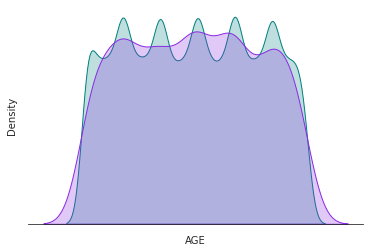

In [17]:
plot = sns.kdeplot(initial, shade=True)
plot = sns.kdeplot(new, shade=True)
plot.set(yticklabels=[], xticklabels = [])
sns.despine(left=True)

In [18]:
def scale_range (input, min, max):
    input += -(np.min(input))
    input /= np.max(input) / (max - min)
    input += min
    return input

buckets = 10
raw_breakpoints = np.arange(0, buckets + 1) / (buckets) * 100
breakpoints = scale_range(raw_breakpoints, np.min(initial), np.max(initial))

In [19]:
initial_counts = np.histogram(initial, breakpoints)[0]
new_counts = np.histogram(new, breakpoints)[0]

In [20]:
df1 = pd.DataFrame({'Bucket': np.arange(1, 11), 'Breakpoint Value':breakpoints[1:], 'Initial Count':initial_counts, 'New Count':new_counts})
df1['Initial Percent'] = df1['Initial Count'] / len(initial)
df1['New Percent'] = df1['New Count'] / len(new)

In [21]:
df1['New Percent'][df1['New Percent'] == 0] = 0.001

In [22]:
df1

,Bucket,Breakpoint Value,Initial Count,New Count,Initial Percent,New Percent
0,1,23.3,11516,231,0.11516,0.1155
1,2,28.6,9963,201,0.09963,0.1005
2,3,33.9,8333,160,0.08333,0.0800
3,4,39.2,11425,221,0.11425,0.1105
4,5,44.5,8293,180,0.08293,0.0900
5,6,49.8,9864,197,0.09864,0.0985
6,7,55.1,11559,256,0.11559,0.1280
7,8,60.4,8249,147,0.08249,0.0735
8,9,65.7,9736,197,0.09736,0.0985
9,10,71.0,9910,193,0.09910,0.0965


In [23]:
percents = df1[['Initial Percent', 'New Percent', 'Bucket']] \
             .melt(id_vars=['Bucket']) \
             .rename(columns={'variable':'Population', 'value':'Percent'})
percents.head()

,Bucket,Population,Percent
0,1,Initial Percent,0.11516
1,2,Initial Percent,0.09963
2,3,Initial Percent,0.08333
3,4,Initial Percent,0.11425
4,5,Initial Percent,0.08293


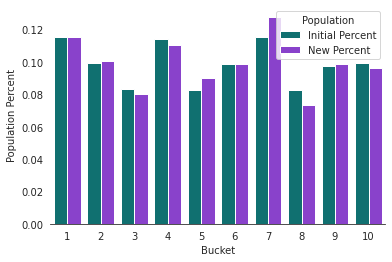

In [24]:
p = sns.barplot(x="Bucket", y="Percent", hue="Population", data=percents)
p.set(xlabel='Bucket', ylabel='Population Percent')
sns.despine(left=True)

$PSI = \sum{}\Big(\big(Actual \% - Expected \%\big) \times ln\big(\dfrac{Actual \%}{Expected \%}\big)\Big)$

In [25]:
df1['PSI'] = (df1['New Percent'] - df1['Initial Percent']) * np.log(df1['New Percent'] / df1['Initial Percent'])

In [26]:
df1.head()

,Bucket,Breakpoint Value,Initial Count,New Count,Initial Percent,New Percent,PSI
0,1,23.3,11516,231,0.11516,0.1155,0.000001
1,2,28.6,9963,201,0.09963,0.1005,0.000008
2,3,33.9,8333,160,0.08333,0.0800,0.000136
3,4,39.2,11425,221,0.11425,0.1105,0.000125
4,5,44.5,8293,180,0.08293,0.0900,0.000578


In [27]:
pd.DataFrame(df1).to_csv('/home/datascience/PSI_AGE.csv')
#np.sum(df1['PSI'])

In [28]:
breakpoints = np.stack([np.percentile(initial, b) for b in np.arange(0, buckets + 1) / (buckets) * 100])

In [29]:
initial_counts = np.histogram(initial, breakpoints)[0]
new_counts = np.histogram(new, breakpoints)[0]

In [30]:
df1 = pd.DataFrame({'Bucket': np.arange(1, 11), 'Breakpoint Value':breakpoints[1:], 'Initial Count':initial_counts, 'New Count':new_counts})
df1['Initial Percent'] = df1['Initial Count'] / len(initial)
df1['New Percent'] = df1['New Count'] / len(new)
df1['New Percent'][df1['New Percent'] == 0] = 0.001
percents = df1[['Initial Percent', 'New Percent', 'Bucket']] \
             .melt(id_vars=['Bucket']) \
             .rename(columns={'variable':'Population', 'value':'Percent'})

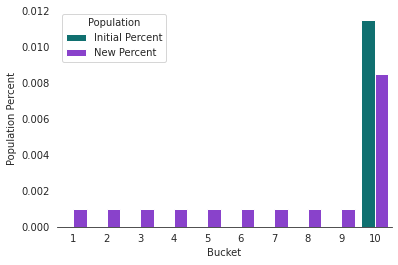

In [31]:
p = sns.barplot(x="Bucket", y="Percent", hue="Population", data=percents)
p.set(xlabel='Bucket', ylabel='Population Percent')
sns.despine(left=True)

In [32]:
calculate_psi(initial, new, buckettype='quantiles', buckets=10, axis=1)

0.0009181358451498527

In [33]:
df = DatasetFactory.from_dataframe(ds, target="Home_Loan_Approval_Prediction")

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

# ADS : Automated Data Quality Check
# let's ask the ADS to provide us some recommendations

In [34]:
print('suggest_recommendations ...')
suggestion_df = df.suggest_recommendations()

suggest_recommendations ...


# ADS : Automated data profiling and preparation
## Data Exploration & Preparation

### Performing Data Visualization

In [35]:
df.show_in_notebook()

Accordion(children=(HTML(value='<h1>Name: User Provided DataFrame</h1><h3>Type: BinaryClassificationDataset</h…

In [36]:
#df.target.show_in_notebook()

In [37]:
#df.plot("DELINQUENCY_STATUS").show_in_notebook(figsize=(4,4)) # figsize optional

In [38]:
#df.plot(x="TENURE", y="LOAN_AMOUNT").show_in_notebook()

# ADS : Automated Feature Engineering & Data Transformation

In [39]:
transformed_ds = df.auto_transform(fix_imbalance=False)

loop1:   0%|          | 0/7 [00:00<?, ?it/s]

In [40]:
#calculate_psi(train.X,test.X, buckettype='bins', buckets=10, axis=0)

In [41]:
train, test = transformed_ds.train_test_split()

In [42]:
%%writefile dataframelabelencoder.py 

from category_encoders.ordinal import OrdinalEncoder
from collections import defaultdict

from sklearn.base import TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

class DataFrameLabelEncoder(TransformerMixin):
    def __init__(self):
        self.label_encoders = defaultdict(LabelEncoder)
        
    def fit(self, X):
        for column in X.columns:
            if X[column].dtype.name  in ["object", "category"]:
                self.label_encoders[column] = OrdinalEncoder()
                self.label_encoders[column].fit(X[column])
        return self
    
    def transform(self, X):
        for column, label_encoder in self.label_encoders.items():
            X[column] = label_encoder.transform(X[column])
        return X

Overwriting dataframelabelencoder.py


# ADS : Automated machine learning (Oracle AutoML)
## Model Training & Evaluation

In [43]:
from dataframelabelencoder import DataFrameLabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
X = train.X.copy()
y = train.y.copy()

le = DataFrameLabelEncoder()
X = le.fit_transform(X)

sk_clf = RandomForestClassifier(random_state=0, max_depth = 7)
sk_clf.fit(X, y)

sk_model = make_pipeline(le, sk_clf)

# Build an ads model from the SVM classifier
my_model = ADSModel.from_estimator(sk_model, 
                                   name=sk_clf.__class__.__name__)

In [44]:
def plot_feature_importance(importance,names,model_type):
    

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

## Feature_importance

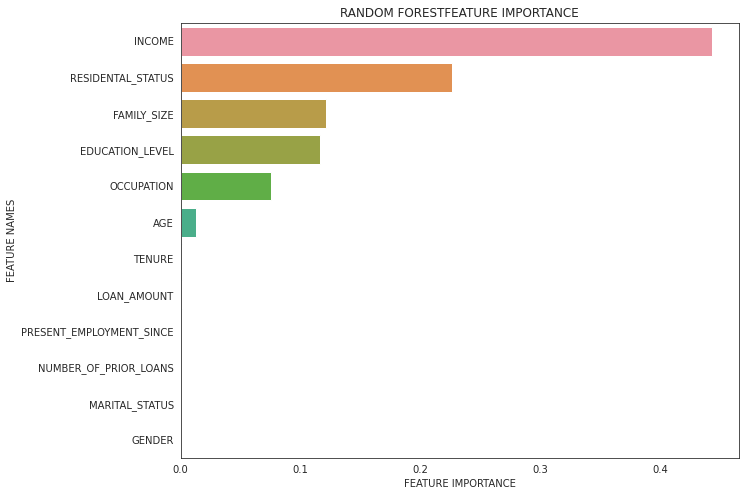

In [45]:
plot_feature_importance(sk_clf.feature_importances_,X.columns,'RANDOM FOREST')

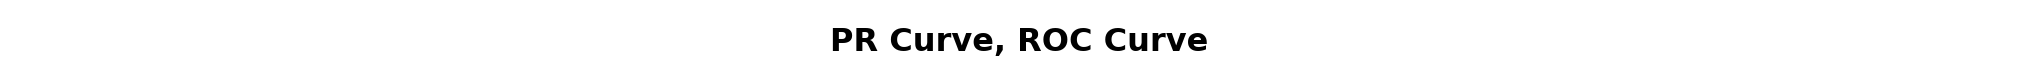

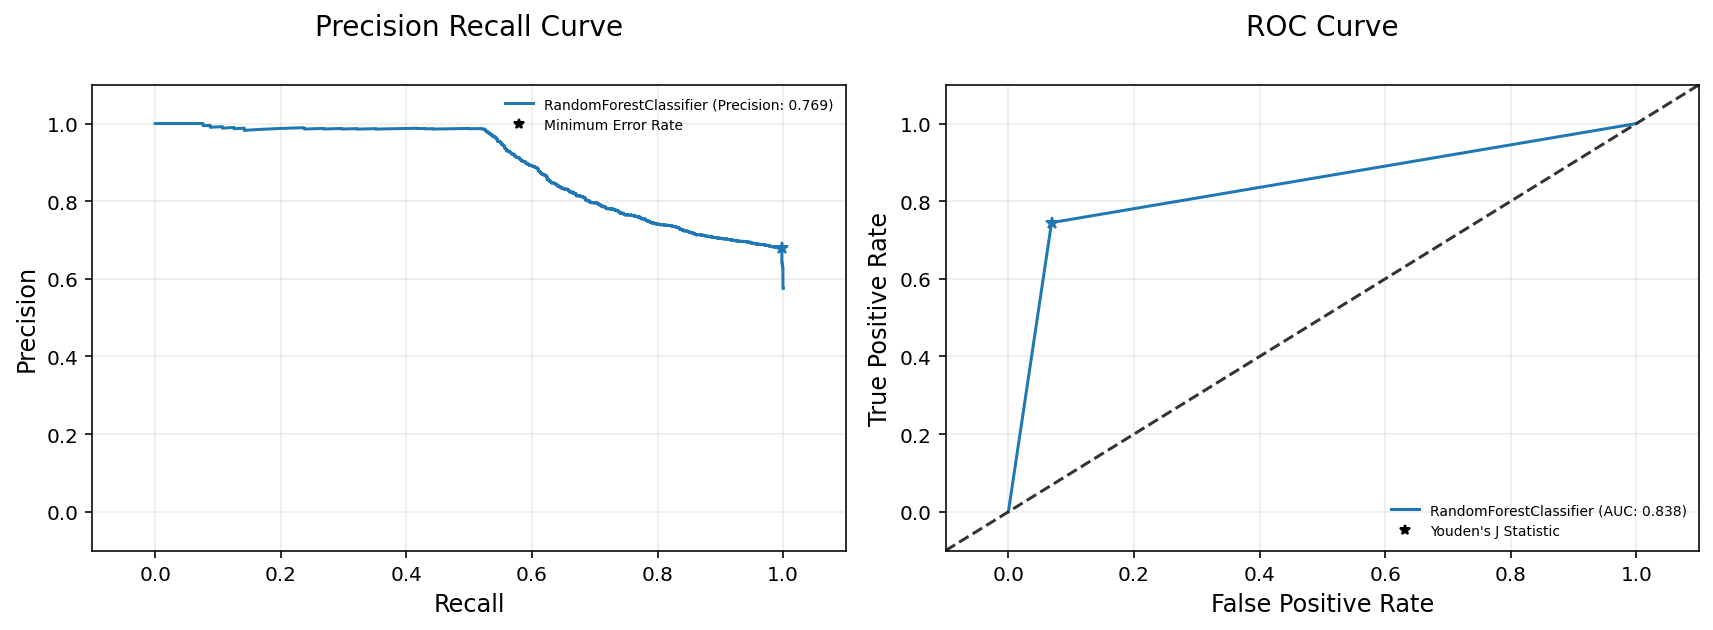

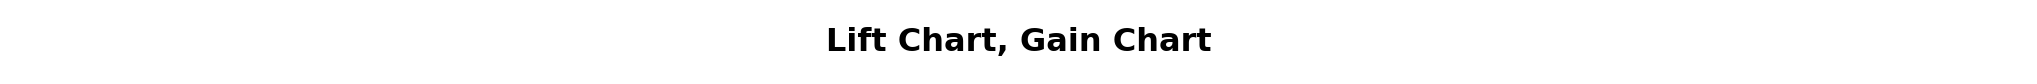

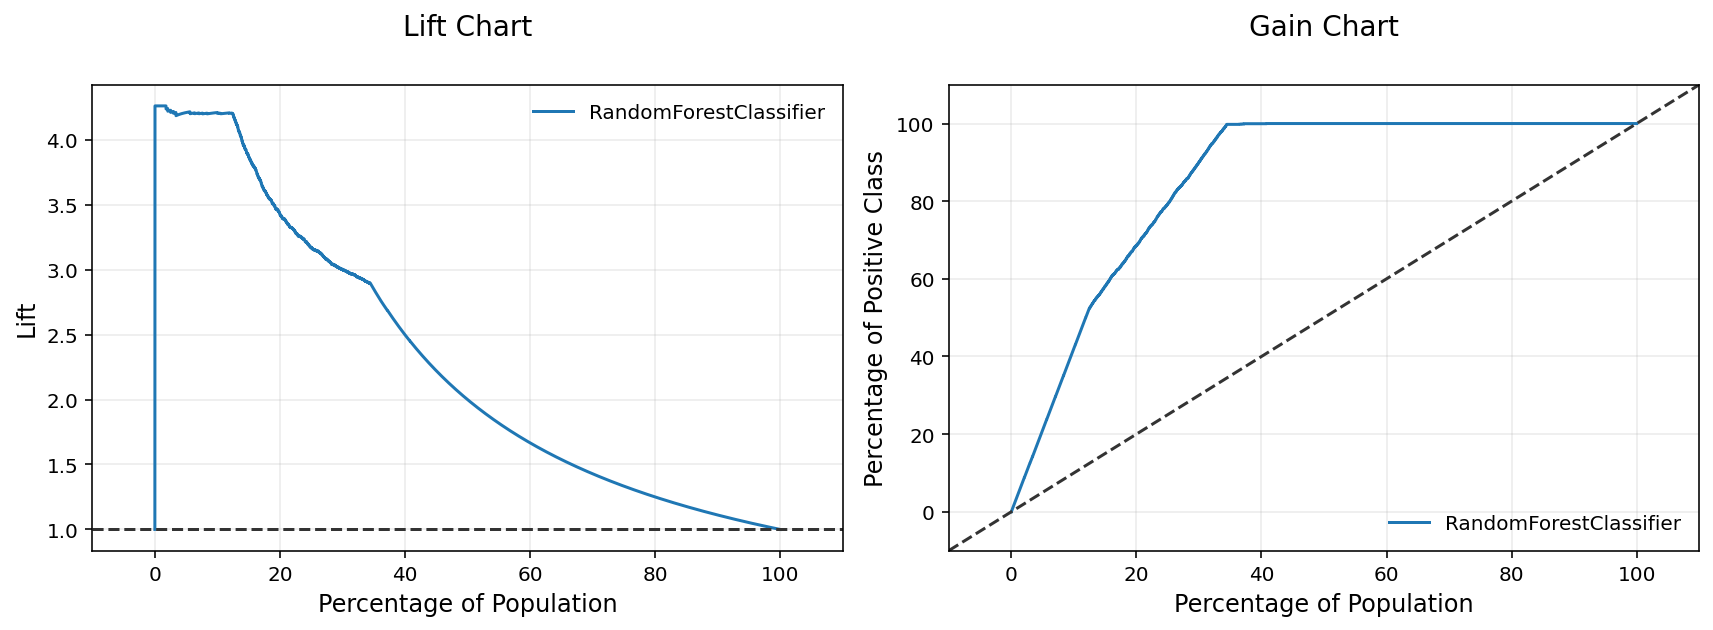

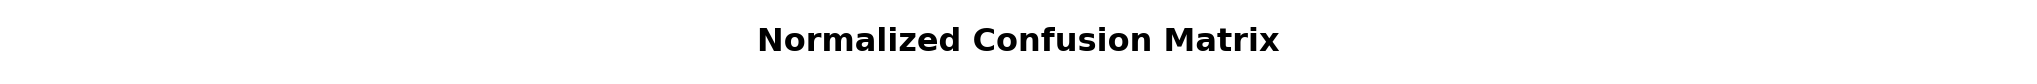

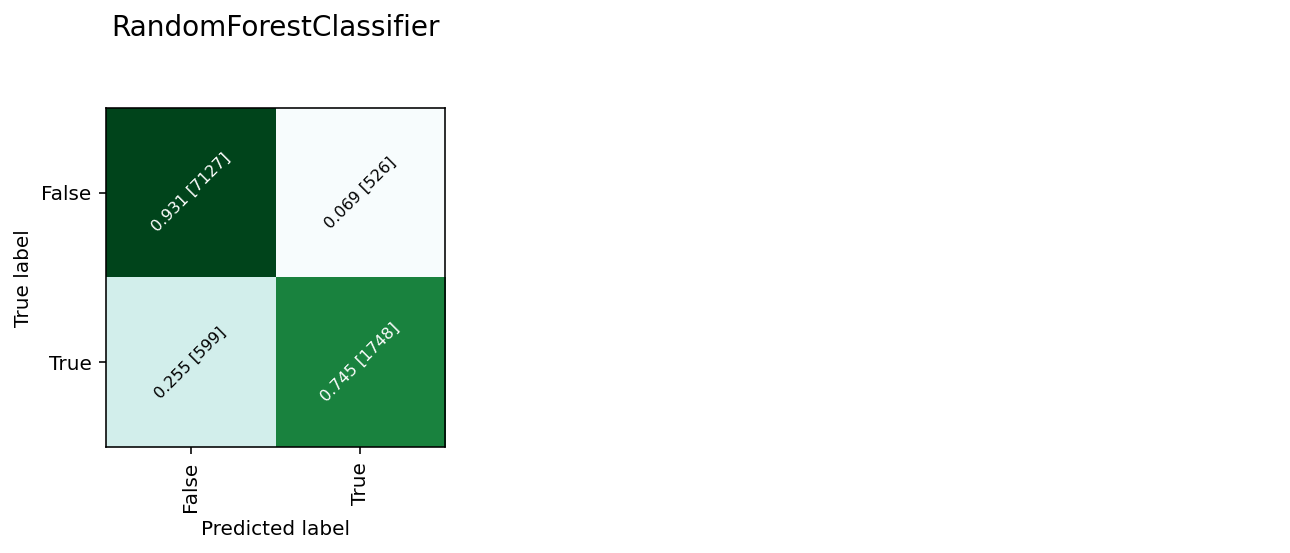

In [46]:
evaluator = ADSEvaluator(test, models=[my_model], 
                         training_data=train)
evaluator.show_in_notebook()

In [47]:
evaluator.metrics

HTML(value='<style type="text/css">\n#T_0d165_row0_col0, #T_0d165_row1_col0, #T_0d165_row2_col0, #T_0d165_row3…

HTML(value='<style type="text/css">\n#T_27cac_row0_col0, #T_27cac_row1_col0, #T_27cac_row2_col0, #T_27cac_row3…

In [48]:
#sk_model.score(test.X,test.y)

In [49]:
#evaluator.calculate_cost(tn_weight=1, fp_weight=3, fn_weight=2, tp_weight=2)
skmodel = ADSModel.from_estimator(sk_model)

# ADS : Automated hyperparameter tuning
## Builing better model 

In [50]:
from ads.hpo.stopping_criterion import *
from ads.hpo.distributions import *
from ads.hpo.search_cv import ADSTuner

In [51]:
from ads.hpo.stopping_criterion import *
from ads.hpo.search_cv import ADSTuner
from sklearn.svm import SVC

In [52]:
tuner = ADSTuner(sk_clf, cv = 5, strategy='detailed')

[I 2022-02-21 08:07:55,456] A new study created in RDB with name: hpo_15bd6fa3-50d2-420d-a5fa-4256adb3bb81


In [53]:
#tuner.tune(train.X, train.y, exit_criterion=[NTrials(100)])
tuner.tune(X , y , exit_criterion=[NTrials(100), TimeBudget(500), ScoreValue(90)])

In [54]:
tuner.trials

,number,value,datetime_start,datetime_complete,duration,params_n_estimators,state
0,0,None,2022-02-21 08:07:55.651138,None,None,246,RUNNING


In [55]:
print('Search Space for default strategy "{}" is \n \n {}'.format(tuner.strategy, tuner.search_space()))

Search Space for default strategy "detailed" is 
 
 {'n_estimators': IntUniformDistribution(low=50, high=500, step=1), 'max_depth': IntUniformDistribution(low=1, high=10, step=1), 'max_features': CategoricalDistribution(choices=['sqrt', 'log2']), 'min_impurity_decrease': UniformDistribution(low=0.0, high=0.05), 'min_samples_split': IntUniformDistribution(low=2, high=500, step=1), 'min_samples_leaf': IntUniformDistribution(low=5, high=25, step=1), 'min_weight_fraction_leaf': UniformDistribution(low=0.0, high=0.5)}


In [56]:
#print(f"The index of the best trial is {tuner.best_index} out of a total of {tuner.n_trials} trials.")

In [57]:
#print('So far the best {} score is {}'.format(tuner.scoring_name, tuner.best_score))

In [58]:
tuner.halt()
tuner.resume()

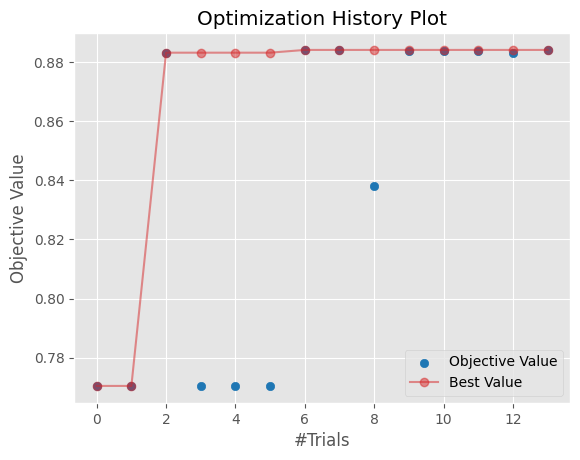

In [59]:
tuner.plot_best_scores()

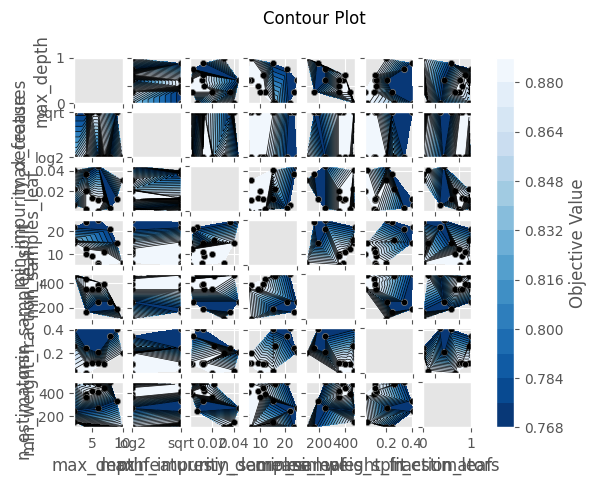

In [60]:
tuner.plot_contour_scores()

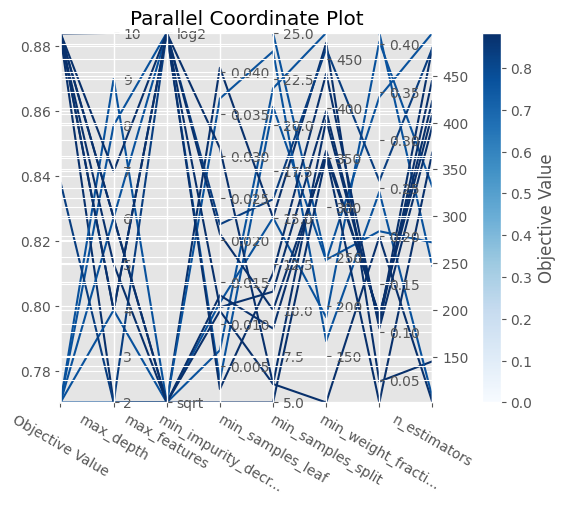

In [61]:
tuner.plot_parallel_coordinate_scores()

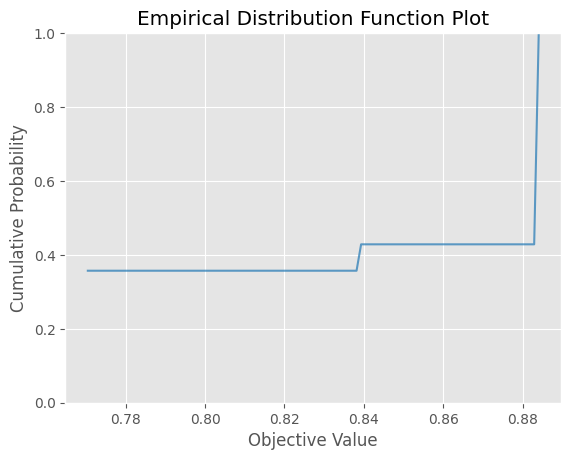

In [62]:
tuner.plot_edf_scores()

ERROR:ads.hpo.search_cv:Pruning was not used during tuning. There are no intermediate values to plot.


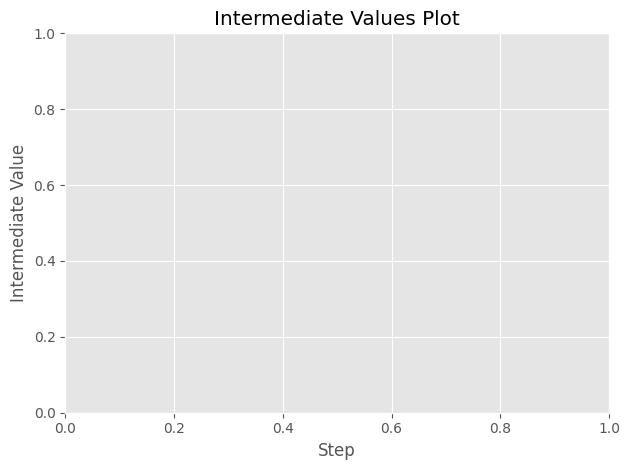

In [63]:
tuner.plot_intermediate_scores()

In [64]:
tuner.trials.loc[tuner.best_index, :]

number                                                      6
value                                                0.884089
datetime_start                     2022-02-21 08:10:29.599817
datetime_complete                  2022-02-21 08:11:20.913030
duration                               0 days 00:00:51.313213
params_max_depth                                            4
params_max_features                                      log2
params_min_impurity_decrease                         0.002231
params_min_samples_leaf                                    12
params_min_samples_split                                  435
params_min_weight_fraction_leaf                      0.103735
params_n_estimators                                       397
user_attrs_mean_fit_time                             9.791773
user_attrs_mean_score_time                           0.425637
user_attrs_mean_test_score                           0.884089
user_attrs_metric                               mean accuracy
user_att

In [65]:
tuner.best_params

{'max_depth': 4,
 'max_features': 'log2',
 'min_impurity_decrease': 0.0022308382714825103,
 'min_samples_leaf': 12,
 'min_samples_split': 435,
 'min_weight_fraction_leaf': 0.10373508019973798,
 'n_estimators': 397}

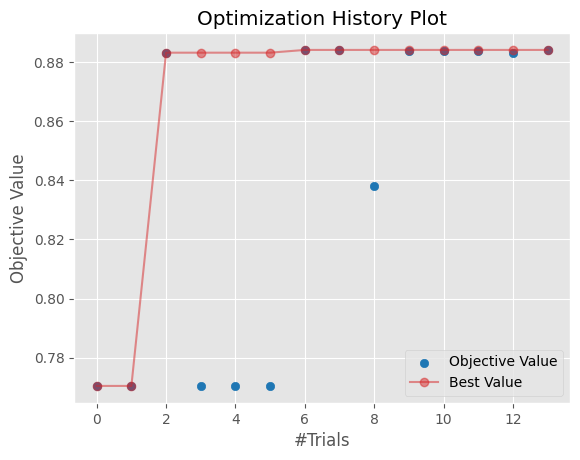

In [66]:
tuner.plot_best_scores()

## ML Model Accuracy

In [67]:
#print("The ML Model Accuracy on test datasets is:", sk_model.score(test.X,test.y))
evaluator.metrics


HTML(value='<style type="text/css">\n#T_19ae0_row0_col0, #T_19ae0_row1_col0, #T_19ae0_row2_col0, #T_19ae0_row3…

HTML(value='<style type="text/css">\n#T_8d505_row0_col0, #T_8d505_row1_col0, #T_8d505_row2_col0, #T_8d505_row3…

# Candidate Model

In [68]:
# Saving the model to the model catalog

In [69]:
from ads.common.model_artifact import ModelArtifact
from ads.common.model_export_util import prepare_generic_model
import joblib 
#sk_clf = RandomForestClassifier(random_state=0, max_depth = 7)
#sk_clf.fit(X, y)
#sk_model = make_pipeline(le, sk_clf)
# Path to artifact directory for my sklearn model: 
sklearn_path = "./MLOPS_Bank_V12/"

# Creating the artifact template files in the directory: 
sklearn_artifact = prepare_generic_model(sklearn_path, 
                                         inference_conda_env="oci://service-conda-packs@id19sfcrra6z/service_pack/cpu/TensorFlow 2.6 for CPU Python 3.7/1.0/tensorflow26_p37_cpu_v2_1",
                                         force_overwrite=True,
                                         use_case_type='BINARY_CLASSIFICATION',
                                         X_sample=train.X,
                                         y_sample=train.y)

# Creating a joblib pickle object of my random forest model: 
joblib.dump(sk_model, os.path.join(sklearn_path, "model.joblib"))

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

['./MLOPS_Bank_V12/model.joblib']

In [70]:
#setting paths for artifact files that need to be modified: 
encoder_path = os.path.join(sklearn_path, "dataframelabelencoder.py")
score_path = os.path.join(sklearn_path, "score.py")
!cp dataframelabelencoder.py {encoder_path}

In [71]:
%%writefile {score_path}

"""
   Inference script. This script is used for prediction by scoring server when schema is known.
"""

import json
import os
from joblib import load
import io 
import pandas as pd
import logging 

# logging configuration - OPTIONAL 
logging.basicConfig(format='%(name)s - %(levelname)s - %(message)s', level=logging.INFO)
logger_pred = logging.getLogger('model-prediction')
logger_pred.setLevel(logging.INFO)
logger_feat = logging.getLogger('input-features')
logger_feat.setLevel(logging.INFO)

from dataframelabelencoder import DataFrameLabelEncoder

def load_model():
    """
    Loads model from the serialized format

    Returns
    -------
    model:  a model instance on which predict API can be invoked
    """
    model_dir = os.path.dirname(os.path.realpath(__file__))
    contents = os.listdir(model_dir)
    model_file_name = "model.joblib"
    # TODO: Load the model from the model_dir using the appropriate loader
    # Below is a sample code to load a model file using `cloudpickle` which was serialized using `cloudpickle`
    # from cloudpickle import cloudpickle
    if model_file_name in contents:
        with open(os.path.join(os.path.dirname(os.path.realpath(__file__)), model_file_name), "rb") as file:
            model = load(file) # Use the loader corresponding to your model file.
    else:
        raise Exception('{0} is not found in model directory {1}'.format(model_file_name, model_dir))
    
    return model


def predict(data, model=load_model()) -> dict:
    """
    Returns prediction given the model and data to predict

    Parameters
    ----------
    model: Model instance returned by load_model API
    data: Data format as expected by the predict API of the core estimator. For eg. in case of sckit models it could be numpy array/List of list/Panda DataFrame

    Returns
    -------
    predictions: Output from scoring server
        Format: { 'prediction': output from `model.predict` method }

    """
    assert model is not None, "Model is not loaded"
    X = pd.read_json(io.StringIO(data)) if isinstance(data, str) else pd.DataFrame.from_dict(data)
    preds = model.predict(X).tolist()
    #logger_pred.info(preds)
    #logger_feat.info(X)    
    return { 'prediction': preds }

Overwriting ./MLOPS_Bank_V12/score.py


In [72]:
# Testing the artifact before saving to the catalog

In [73]:
input_data = train.X[:5]

In [74]:
import sys 

# add the path of score.py: 
sys.path.insert(0, sklearn_path)

from score import load_model, predict

# Load the model to memory 
_ = load_model()
# make predictions on the first five rows of the training dataset: 
predictions = predict(input_data.to_json()) 

# The two lists should match:
print(f"* * * score.predict() and the pipeline predict() return the same predictions \
on the same data: {sk_model.predict(input_data).tolist() == predictions['prediction']}")

* * * score.predict() and the pipeline predict() return the same predictions on the same data: True


# Saving the Model to the Model Catalog

In [75]:

mc_model = sklearn_artifact.save(project_id=os.environ['PROJECT_OCID'], 
                               compartment_id=os.environ['NB_SESSION_COMPARTMENT_OCID'], 
                               training_id=os.environ['NB_SESSION_OCID'],
                               display_name="MLOPS_BANK_V12",
                               description="Sklearn model to predict Bank Loan Application Approval / Rejection", 
                               training_script_path="MLOps_Bank_Loan_Prediction_v6_test.ipynb", 
                               ignore_pending_changes=True)

loop1:   0%|          | 0/5 [00:00<?, ?it/s]

artifact:/tmp/saved_model_827c7256-9c37-4fc7-bdc8-b4fedc16535a.zip


In [76]:
input_data = test.X[:1]


In [77]:
input_data

,MARITAL_STATUS,EDUCATION_LEVEL,RESIDENTAL_STATUS,LOAN_AMOUNT,INCOME,GENDER,NUMBER_OF_PRIOR_LOANS,AGE,TENURE,PRESENT_EMPLOYMENT_SINCE,FAMILY_SIZE,OCCUPATION
75721,Married,Primary School Grad,Family Home,10000.0,500.0,Male,2.0,32.0,13.0,Unemployed,2.0,Clerical


In [78]:
import sys 

# add the path of score.py: 
sys.path.insert(0, sklearn_path)

from score import load_model, predict

# Load the model to memory 
_ = load_model()
# make predictions on the first five rows of the training dataset: 
predictions = predict(input_data.to_json()) 

# The two lists should match:
print(f"* * * score.predict() and the pipeline predict() return the same predictions \
on the same data: {sk_model.predict(input_data).tolist() == predictions['prediction']}")

* * * score.predict() and the pipeline predict() return the same predictions on the same data: True


In [ ]:
####################################################################################################################################